In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde, linregress
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd
import salem
import shapely.geometry as shpg
from matplotlib.colors import LinearSegmentedColormap

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
#%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [21]:
mcs50 = '/home/ck/DIR/mymachine/GRIDSAT/MCS18/gridsat_WA_-50_2010.nc'
mcs70 = '/home/ck/DIR/mymachine/GRIDSAT/MCS18/gridsat_WA_2010.nc'
era = cnst.local_data + 'ERA5/hourly/surface/ERA5_2010_04_srfc.nc'
topo = cnst.TOPO_1MIN

In [4]:
d50 = xr.open_dataarray(mcs50).sel(lon=slice(-18,20), lat=slice(2,23)).sel(time='2010-04-22')
d70 = xr.open_dataarray(mcs70).sel(lon=slice(-18,20), lat=slice(2,23)).sel(time='2010-04-22')
era5 = xr.open_dataset(era)
era5 = uda.flip_lat(era5)
era5 = era5['t2m'].sel(longitude=slice(-18,20), latitude=slice(2,23)).sel(time='2010-04-22')

In [22]:
top = xr.open_dataarray(topo)

In [6]:
era5p = era5[era5['time.hour']==12]-273.15

In [7]:
era5p

<xarray.DataArray 't2m' (time: 1, latitude: 79, longitude: 141)>
array([[[27.76587 , 27.746307, ..., 30.612   , 30.8172  ],
        [27.781616, 27.762604, ..., 30.340027, 30.729797],
        ...,
        [20.82071 , 20.694763, ..., 29.877533, 29.92746 ],
        [20.893982, 20.775116, ..., 29.685913, 29.717377]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 16.5 16.75 17.0
  * latitude   (latitude) float32 3.5 3.75 4.0 4.25 ... 22.25 22.5 22.75 23.0
  * time       (time) datetime64[ns] 2010-04-22T12:00:00

In [8]:
#d70.values[d70.values>-70] = np.nan
d50.values[d50.values>-50] = np.nan
lon,lat = np.meshgrid(d70.lon, d70.lat)


In [9]:
lats = lat[d70.squeeze().values<=-70]
lons = lon[d70.squeeze().values<=-70]

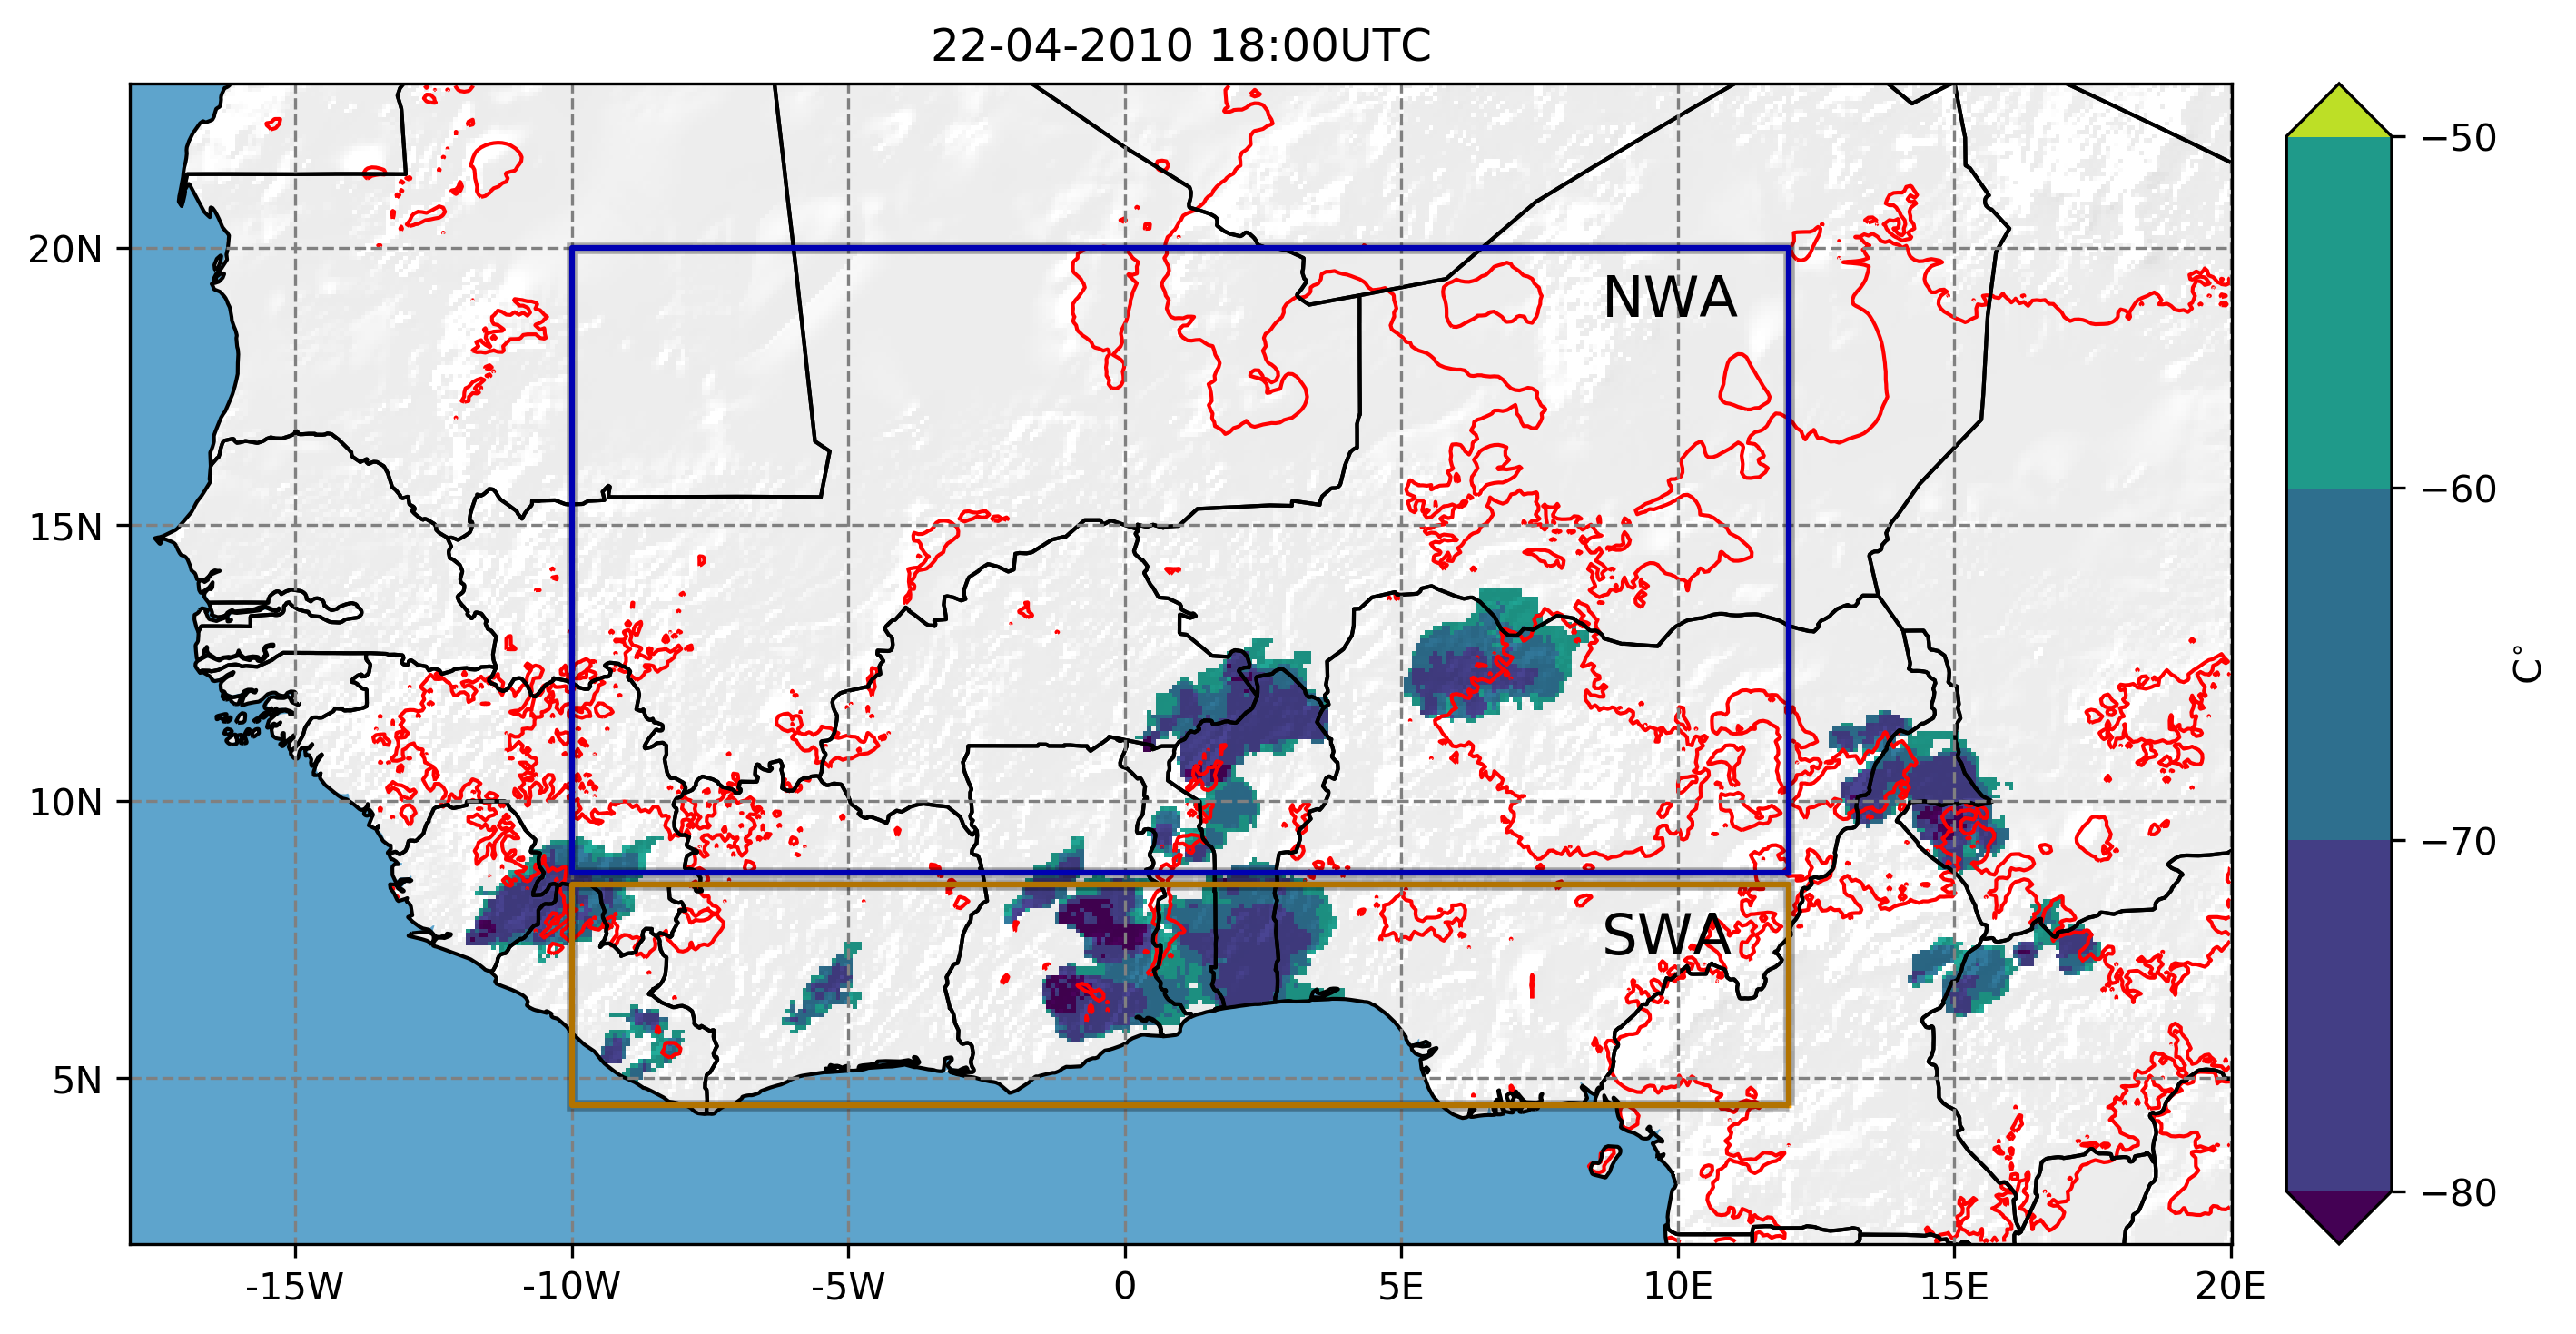

In [24]:
fp = ''
cmap = mpl.cm.viridis(np.linspace(0,0.9,6))
cmap = mpl.colors.ListedColormap(cmap)

map = d50.salem.get_map()
x, y = map.grid.transform(lons, lats)

f = plt.figure(figsize=(10,5), dpi=300)

ax = f.add_subplot(111)

#map.set_rgb(natural_earth='lr')
map.set_plot_params(levels=[-80,-70,-60,-50], cmap=cmap, extend='both')

 # interp='linear'
#map.set_shapefile(rivers=True)
z = map.set_topography(top,relief_factor=0.7)

map.set_contour((z).astype(np.float64), interp='linear', colors='red', linewidths=1, levels=[450,7000]) #d70.values
#   # levels=np.arange(-0.5,0.51,0.1),
map.set_data(d50) 
# map.set_contour(era5p, interp='linear', colors='red', linewidths=1, levels=[35,50])
#   # levels=np.arange(-0.5,0.51,0.1),

coord = [-10, 12, 4.5, 8.5]
geom = shpg.box(coord[0], coord[2], coord[1], coord[3])
map.set_geometry(geom, zorder=99, edgecolor='orange', linewidth=3,  alpha=0.3, facecolor='none')

coord = [-10, 12, 8.7, 20]
geom = shpg.box(coord[0], coord[2], coord[1], coord[3])
map.set_geometry(geom, zorder=99, edgecolor='blue', linewidth=3,  alpha=0.3, facecolor='none')
plt.text(0.7,0.25, 'SWA',transform=ax.transAxes, fontsize=15)
plt.text(0.7,0.8, 'NWA',transform=ax.transAxes, fontsize=15)
# coord = [-10, 20, 9, 20]
# geom = shpg.box(coord[0], coord[2], coord[1], coord[3])
# map.set_geometry(geom, zorder=99, edgecolor='purple', linewidth=3,  alpha=0.3, facecolor='none')
map.set_shapefile(oceans=True)
# Add the background (other resolutions include: 'mr', 'hr')



#plt.text(70,220,'June-September', fontsize=11)
#plt.scatter(x, y, facecolor='yellow', edgecolors='yellow', zorder=99, s=0.15)
dic = map.visualize(ax=ax, title='22-04-2010 18:00UTC', cbar_title='C$^{\circ}$')

# contours = dic['contour'][0]
# plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')

plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/paper1/fig1_0.jpg')

In [158]:
era_srfc = xr.open_dataset(cnst.ERA5_MONTHLY_SRFC_SYNOP)
era_pl = xr.open_dataset(cnst.ERA5_MONTHLY_PL_SYNOP)
ccover = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_mean_5000km2.nc')
ccover50 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-50_monthly_count.nc')
#ccover50['tir'].values = ccover50['tir'].values
#chirps = xr.open_mfdataset(cnst.CHIRPS + "*.nc")

In [149]:
chirps = xr.open_mfdataset(cnst.CHIRPS_MONTHLY + "*.nc", concat_dim='time',autoclose=True)
chirps = uda.flip_lat(chirps)

In [156]:
chov = chirps.sel(lat=slice(5,8.5), lon=slice(-10,10)).groupby('time.month').mean(['time', 'lat', 'lon'])

In [159]:
era_srfc = uda.flip_lat(era_srfc)
era_pl = uda.flip_lat(era_pl)
era_pl = era_pl.sel(longitude=slice(-10,10), latitude=slice(5,8.5))
era_srfc = era_srfc.sel(longitude=slice(-10,10), latitude=slice(5,8.5))
era_srfc = era_srfc.where((era_srfc['t2m'])['time.hour'] == 12, drop=True)
era_pl = era_pl.where((era_pl['q'])['time.hour'] == 12, drop=True)

In [160]:
era_pl = era_pl.mean(['longitude']).groupby('time.month').max('latitude').groupby('time.month').mean('time')
era_srfc = era_srfc.mean(['longitude']).groupby('time.month').max('latitude').groupby('time.month').mean('time')

/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [161]:
ddiv = div['q']*1000*div['d']

In [162]:
cmean_coll = ccover['tir'].sel(lat=slice(5,8.5), lon=slice(-10,10)).mean(['lon']).groupby('time.month').max('lat').groupby('time.month').mean('time')
cmean_coll50 = ccover50['tir'].sel(lat=slice(5,8.5), lon=slice(-10,10)).mean(['lon']).groupby('time.month').max('lat').groupby('time.month').mean('time')

In [163]:
shear = era_pl.sel(level=650) - era_pl.sel(level=925)

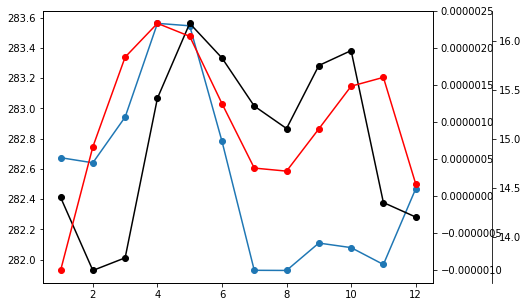

In [164]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111)
ax.plot(range(1,13),era_pl['t'].sel(level=700), '-o')
ax1 = ax.twinx()
ax1.plot(range(1,13),era_pl['d'].sel(level=925), '-ko')
ax2 = ax.twinx()
ax2.spines["right"].set_position(("axes", 1.15))
ax2.plot(range(1,13),era_pl['q'].sel(level=925)*1000, '-ro')

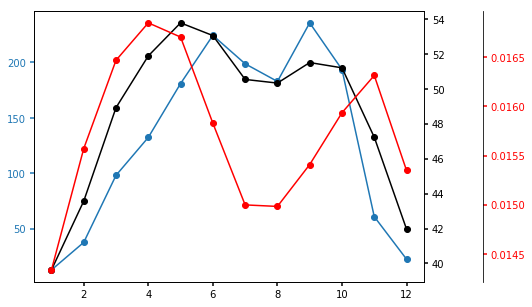

In [165]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111)
p0,=ax.plot(range(1,13),chov['precip'], '-o')
ax1 = ax.twinx()
ax2 = ax.twinx()
p1,=ax1.plot(range(1,13),era_srfc['tcwv'], '-ko')
ax2.spines["right"].set_position(("axes", 1.15))
p2,=ax2.plot(range(1,13),era_pl['q'].sel(level=950), '-ro')

ax.yaxis.label.set_color(p0.get_color())
ax1.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p0.get_color(), **tkw)
ax1.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)

ax.tick_params(axis='x', **tkw)

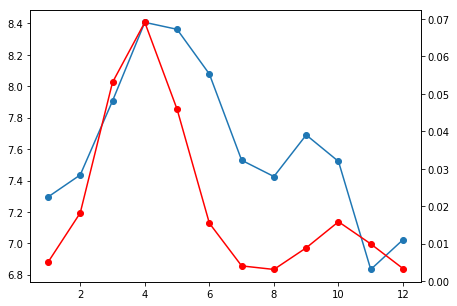

In [167]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111)
ax.plot(range(1,13),era_pl['t'].sel(level=700)-era_pl['t'].sel(level=600), '-o') # 700-600 T mean['t']-mean3['t']
ax1 = ax.twinx()
#ax1.plot(range(1,13),cmean_coll, '-ko')
#ax1.plot(range(1,13),cmean_coll50/30, '-ro')
ax1.plot(range(1,13),cmean_coll, '-ro') #/(cmean_coll50/30)*100